# 巡回セールスマン問題

* 混合整数計画問題として解く(0-1変数と実数変数)
* PythonのソルバーであるPuLPを利用する
* 巡回路の距離が最小になる組み合わせを探す
* 以下のコードで計算できるのは初期地点を除く7配送地点まで

<a href="https://colab.research.google.com/github/ToumaTanaka/Data_Science/blob/main/Mathematical_Optimization/Traveling_salesman_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install pulp

In [229]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt
import math
from google.colab import files
import time

In [240]:
#配送地点のデータを読み込む
df = pd.read_csv('data.csv')
#df = pd.read_csv('5配送地点仮想データ.csv')
df.head(15)

,Unnamed: 0,x,y
0,0,0,0
1,1,60,1
2,2,11,60
3,3,13,9
4,4,59,64
5,5,26,1
6,6,25,80
7,7,38,65


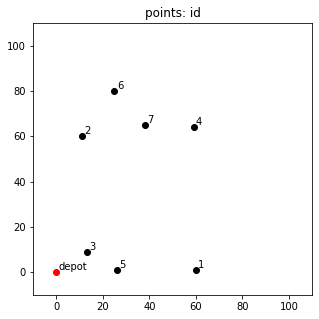

In [241]:
plt.figure(figsize=(5, 5))

for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')

plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id')
plt.show()

In [242]:
a = df.shape[0] 
print(a)

8


In [243]:
#距離のリストを作成
distances = [] 

for i in range(a):
  distances.append([]) 
  for j in range(a):
    x_1 = df.iloc[i,1]
    y_1 = df.iloc[i,2]
    x_2 = df.iloc[j,1]
    y_2 = df.iloc[j,2]
    d = ((x_1 - x_2)**2 +(y_1 - y_2)**2)**(1/2)
    #数値が長くなるので小数点以下切り捨て
    d = math.floor(d)
    distances[i].append(d) 


In [244]:
#変数の定義
#0-1整数のための変数
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(a) for j in range(a)), cat='Binary')

#サブループを回避するための順序を与える変数
u = pulp.LpVariable.dicts('u', (i for i in range(a)), lowBound=1, upBound=n_point, cat='Continuous')

In [245]:
#最小値問題のモデルを定義
problem = pulp.LpProblem('巡回セールスマン問題', sense=pulp.LpMinimize)


#定義したモデルに制約式を追加


#地点Aから別の地点に移動するものはどれか一つ
for i in range(a):
    problem += x[i, i] == 0

#地点Aから別の地点に移動するものはどれか一つ
#別の地点から地点Aに移動するものはどれか一つ
for i in range(a):
    problem += pulp.lpSum(x[i, j] for j in range(a)) == 1
    problem += pulp.lpSum(x[j, i] for j in range(a)) == 1
  


#部分巡回路を排除するような制約にはさまざまなアプローチがある
#MTZ制約
for i in range(a):
    for j in range(a):
        if i != j and (i != 0 and j != 0):
            problem += u[i] - u[j] <= a * (1 - x[i, j]) - 1


#定義したモデルに目的関数を追加
problem += pulp.lpSum(distances[i][j] * x[i, j] for i in range(a) for j in range(a))

In [246]:
# 処理前の時刻
t1 = time.time() 

#解を求める
result = problem.solve()

# 処理後の時刻
t2 = time.time()

elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}")

#現在の状態を表示
#-3: 'Undefined',    未定義
#-2: 'Unbounded',   非有界
#-1: 'Infeasible',     実行不可能
#0: 'Not Solved'    解けなかった
#1: 'Optimal'       最適解を発見
print(pulp.LpStatus[result])

#目的関数の値を表示
print(pulp.value(problem.objective))

経過時間：0.3415393829345703
Optimal
252.0


## 最適化結果の可視化

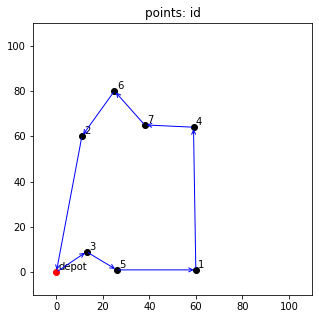

In [247]:
plt.figure(figsize=(5, 5))

for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')

plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id')

#最適化ルートの描画
routes = [(i, j) for i in range(a) for j in range(a) if pulp.value(x[i, j]) == 1]
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in routes:
    plt.annotate('', xy=[df.iloc[j]['x'], df.iloc[j]['y']], xytext=[df.iloc[i]['x'], df.iloc[i]['y']], arrowprops=arrowprops)
plt.show()